In [4]:
!pip install PySpice==1.3.2
!sudo apt-get install ngspice
!ngspice -v
!sudo apt install libngspice0
!pip install stable-baselines3 --upgrade
!pip install gym
!pip install fsspec==2024.10.0
!pip install shimmy>=0.2.1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
******
** ngspice-36 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2020, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Mon Mar 11 21:44:53 UTC 2024
******
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libngspice0 is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1 - Cumulative Reward: -6634.610595703125
Episode 2 - Cumulative Reward: -5436.886474609375
Episode 3 - Cumulative Reward: -4619.7353515625
Episode 4 - Cumulative Reward: -4001.9241333007812
Episode 5 - Cumulative Reward: -3497.5572509765625
Episode 6 - Cumulative Reward: -3056.6107788085938
Episode 7 - Cumulative Reward: -2635.9861450195312
Episode 8 - Cumulative Reward: -2312.014404296875
Episode 9 - Cumulative Reward: -1969.5584411621094
Episode 10 - Cumulative Reward: -1719.5921020507812
Episode 11 - Cumulative Reward: -1475.6286010742188
Episode 12 - Cumulative Reward: -1281.5958862304688
Episode 13 - Cumulative Reward: -1096.6430053710938
Episode 14 - Cumulative Reward: -877.394287109375
Episode 15 - Cumulative Reward: -640.781982421875
Episode 16 - Cumulative Reward: -578.2578125
Episode 17 - Cumulative Reward: -529.156005859375
Episode 18 - Cumulative Reward: -468.8514938354492

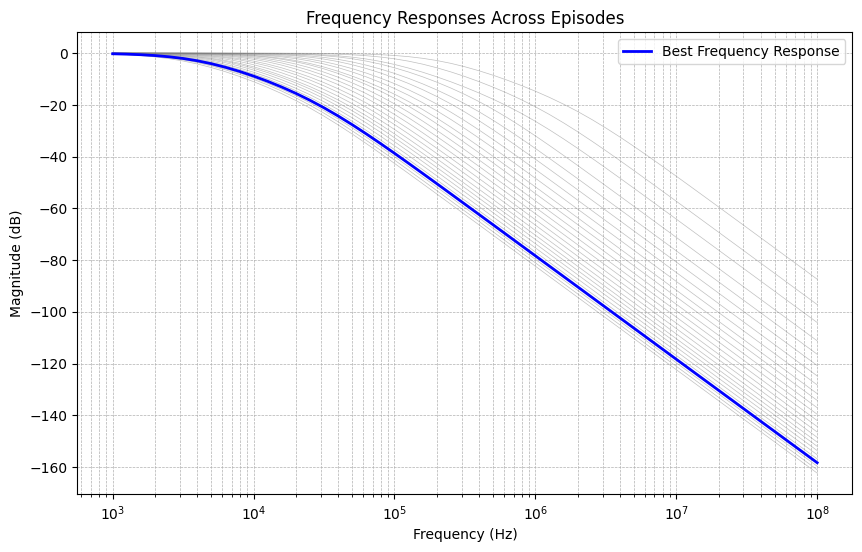

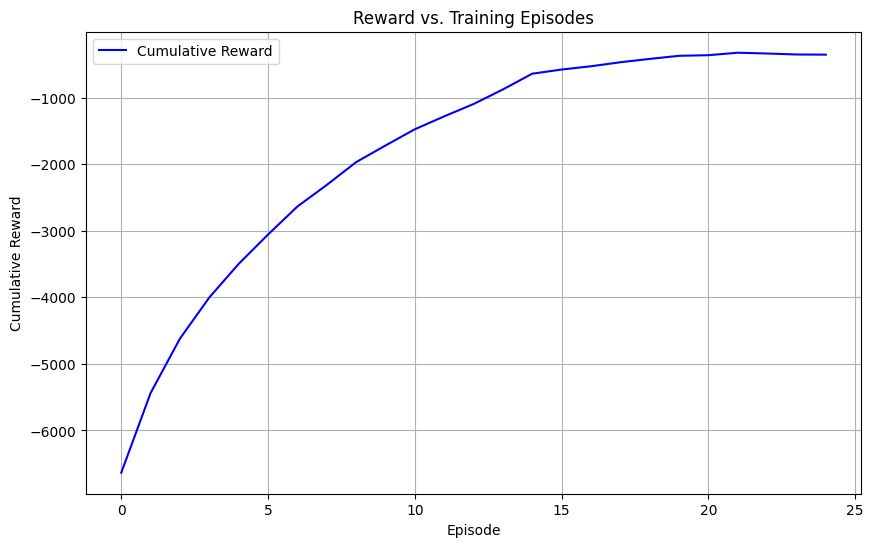

In [29]:
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from gym import Env, spaces

class RewardAndResponseLoggingCallback(BaseCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.episode_rewards = []
        self.all_frequencies = []
        self.all_magnitudes = []
        self.all_cumulative_rewards = []
        self.all_cutoff_frequencies = []

    def _on_step(self):
        # Accumulate rewards for the current episode
        self.episode_rewards.append(self.locals['rewards'][0])
        return True

    def _on_rollout_end(self):
        # Calculate cumulative reward at the end of each episode
        cumulative_reward = sum(self.episode_rewards)
        self.all_cumulative_rewards.append(cumulative_reward)
        self.episode_rewards = []  # Reset for the next episode

        # Get current frequency response from environment and store it
        env = self.training_env.envs[0]
        frequencies, magnitudes = env.run_simulation(env.state)
        self.all_frequencies.append(frequencies)
        self.all_magnitudes.append(magnitudes)

        # Print cumulative reward for debugging
        print(f"Episode {len(self.all_cumulative_rewards)} - Cumulative Reward: {cumulative_reward}")

    def plot_final_reward_vs_episodes(self):
        # Plot cumulative reward vs. episodes after training
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(self.all_cumulative_rewards)), self.all_cumulative_rewards, 'b-', label="Cumulative Reward")
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward")
        plt.title("Reward vs. Training Episodes")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_all_responses(self):
        # Identify the best episode based on the highest cumulative reward
        best_episode_index = np.argmax(self.all_cumulative_rewards)
        best_frequencies = self.all_frequencies[best_episode_index]
        best_magnitudes = self.all_magnitudes[best_episode_index]

        # Plot all responses in light gray
        plt.figure(figsize=(10, 6))
        for frequencies, magnitudes in zip(self.all_frequencies, self.all_magnitudes):
            plt.plot(frequencies, magnitudes, color="gray", linewidth=0.5, alpha=0.5)

        # Highlight the best frequency response in blue
        plt.plot(best_frequencies, best_magnitudes, color="blue", linewidth=2, label="Best Frequency Response")

        # Finalize plot
        plt.xscale("log")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.title("Frequency Responses Across Episodes")
        plt.legend()
        plt.grid(which="both", linestyle="--", linewidth=0.5)
        plt.show()


class FilterDesignEnv(Env):
    def __init__(self, target_cutoff):
        super(FilterDesignEnv, self).__init__()
        self.target_cutoff = target_cutoff
        self.action_space = spaces.Discrete(4)  # Actions to adjust R1, R2, C1, C2
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)
        self.state = np.array([12000, 12000, 1e-9, 1e-9], dtype=np.float32)

    def step(self, action):
        # Smaller adjustments to avoid large penalty steps
        if action == 0:
            self.state[0] += 500
        elif action == 1:
            self.state[1] += 500
        elif action == 2:
            self.state[2] += 5e-11
        elif action == 3:
            self.state[3] += 5e-11

        frequencies, magnitudes = self.run_simulation(self.state)
        reward = reward_function(frequencies, magnitudes, self.target_cutoff)
        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = np.array([1200, 1200, 1e-10, 1e-10], dtype=np.float32)
        return self.state

    def run_simulation(self, component_values):
        r1, r2, c1, c2 = component_values
        netlist = f"""
* Low-pass filter circuit with OPAMP
V1 1 0 AC 1
R1 1 2 {r1}
C2 2 0 {c2}
R2 2 3 {r2}
C1 3 0 {c1}
X1 3 0 4 OPAMP
.subckt OPAMP 1 2 3
E1 3 0 1 2 100k
.ends OPAMP
.ac dec 10 1k 100Meg
.print ac vdb(3)
.end
"""
        with open("filter_netlist.sp", "w") as file:
            file.write(netlist)

        command = "ngspice -b filter_netlist.sp -o output.raw"
        result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        if result.returncode != 0:
            print("NgSpice failed:", result.stderr.decode())
            return [], []

        frequencies, magnitudes = self.parse_output("output.raw")
        return frequencies, magnitudes

    def parse_output(self, file_path):
        frequencies = []
        magnitudes = []
        with open(file_path, "r") as file:
            for line in file:
                data = line.strip().split()
                if len(data) >= 2:
                    try:
                        freq = float(data[1].replace(',', ''))
                        vdb3 = float(data[2].replace(',', ''))
                        frequencies.append(freq)
                        magnitudes.append(vdb3)
                    except ValueError:
                        continue
        return frequencies, magnitudes

def reward_function(frequencies, magnitudes, target_cutoff, passband_tolerance=1, stopband_attenuation=-20):
    reward = 0
    penalty = 0
    for freq, mag in zip(frequencies, magnitudes):
        if freq <= target_cutoff:
            if abs(mag) <= passband_tolerance:
                reward += 5
            else:
                penalty += 5 * abs(mag)
        else:
            if mag <= stopband_attenuation:
                reward += 5
            else:
                penalty += 5 * (mag - stopband_attenuation)
    actual_cutoff = estimate_cutoff_frequency(frequencies, magnitudes, target_cutoff)
    if abs(actual_cutoff - target_cutoff) < 0.1 * target_cutoff:
        reward += 20
    else:
        penalty += 10
    return reward - penalty

def estimate_cutoff_frequency(frequencies, magnitudes, target_cutoff):
    for freq, mag in zip(frequencies, magnitudes):
        if mag <= -3:
            return freq
    return target_cutoff

# Instantiate environment and callback
env = FilterDesignEnv(target_cutoff=10000)
reward_callback = RewardAndResponseLoggingCallback()

# Train the agent
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100, callback=reward_callback)

# Plot all frequency responses after training
reward_callback.plot_all_responses()
reward_callback.plot_final_reward_vs_episodes()
#reward_callback.plot_final_reward_and_cutoff_vs_episodes()